# Machine Learning for Geobiology
## Estimating growth rate from Nutrient levels 
### Isamu Naets

In [1]:
%matplotlib notebook
import pandas as pd 
import numpy as np
import sklearn
from sklearn.impute import KNNImputer,SimpleImputer
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
import copy
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import RobustScaler
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer

In [2]:
training = pd.read_csv('./Datasets/Dataset.csv')
training = training.loc[:, ~training.columns.str.contains('Unnamed')] # Drop extra columns
x_train = training.drop(['Growth Rate','id'],axis=1)
y_train = training['Growth Rate']
print(x_train)
assert x_train.shape[0] == y_train.shape[0]

     Temperature  Carbon  Nitrogen  O2   CO2   pH
0            NaN     NaN       NaN NaN   0.5  NaN
1            NaN     NaN       NaN NaN  49.4  NaN
2           35.0     NaN       NaN NaN   NaN  NaN
3           30.0     NaN       NaN NaN  29.2  NaN
4           25.0     NaN       NaN NaN   NaN  NaN
..           ...     ...       ...  ..   ...  ...
644         20.0     NaN       NaN NaN   NaN  7.5
645         20.0     NaN       NaN NaN   NaN  7.5
646         20.0     NaN       NaN NaN   NaN  7.5
647         20.0     NaN       NaN NaN   NaN  7.5
648         20.0     NaN       NaN NaN   NaN  7.5

[649 rows x 6 columns]


### Impute the missing data for the nan's 

In [3]:
# Impute the data using the simple imputer 
imputer = KNNImputer(n_neighbors=10)
knn_imputed_x = imputer.fit_transform(x_train)
knn_imputed_x = pd.DataFrame(knn_imputed_x, columns = x_train.columns)
# Impute the data using KNN imputer 
imputer = SimpleImputer()
simple_imputed_x = imputer.fit_transform(x_train)
simple_imputed_x = pd.DataFrame(simple_imputed_x, columns = x_train.columns)
iterative_imputer = IterativeImputer(max_iter=50,sample_posterior=True,verbose=2,min_value=0)
iterative =iterative_imputer.fit_transform(x_train)
iterative = pd.DataFrame(iterative,columns=x_train.columns)
X_imputed_df = pd.DataFrame(knn_imputed_x, columns = x_train.columns)
#Check that all labels are imputed
np.isfinite(np.sum(simple_imputed_x))

[IterativeImputer] Completing matrix with shape (649, 6)
[IterativeImputer] Ending imputation round 1/50, elapsed time 0.33
[IterativeImputer] Ending imputation round 2/50, elapsed time 0.67
[IterativeImputer] Ending imputation round 3/50, elapsed time 1.04
[IterativeImputer] Ending imputation round 4/50, elapsed time 1.38
[IterativeImputer] Ending imputation round 5/50, elapsed time 1.74
[IterativeImputer] Ending imputation round 6/50, elapsed time 2.13
[IterativeImputer] Ending imputation round 7/50, elapsed time 2.49
[IterativeImputer] Ending imputation round 8/50, elapsed time 2.82
[IterativeImputer] Ending imputation round 9/50, elapsed time 3.17
[IterativeImputer] Ending imputation round 10/50, elapsed time 3.53
[IterativeImputer] Ending imputation round 11/50, elapsed time 3.89
[IterativeImputer] Ending imputation round 12/50, elapsed time 4.24
[IterativeImputer] Ending imputation round 13/50, elapsed time 4.59
[IterativeImputer] Ending imputation round 14/50, elapsed time 4.94


Temperature    True
Carbon         True
Nitrogen       True
O2             True
CO2            True
pH             True
dtype: bool

In [4]:
knn_imputed_x["Growth Rate"]

KeyError: 'Growth Rate'

<IPython.core.display.Javascript object>


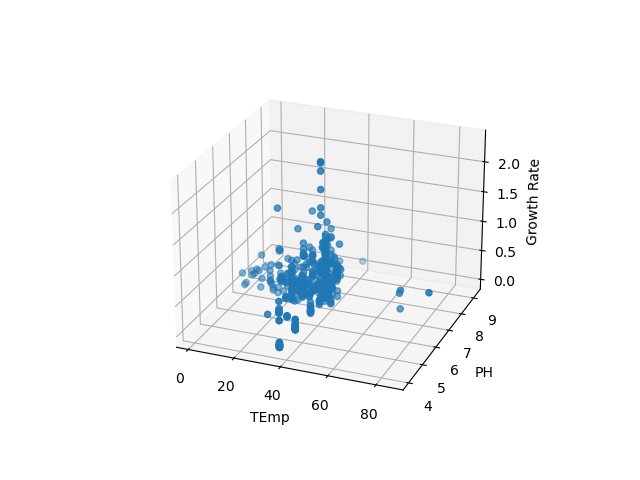

In [12]:
from mpl_toolkits.mplot3d import axes3d    


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(iterative['Temperature'],knn_imputed_x['pH'],y_train)
ax.set_xlabel('TEmp')
ax.set_ylabel('PH')
ax.set_zlabel('Growth Rate')
plt.show()

In [37]:
#Check for outliers using IsolationForest method
labels = x_train.columns
print(labels)
isf = IsolationForest(n_jobs=-1, random_state=1,max_features=6,n_estimators=5)
isf.fit(X_imputed_df[labels], y_train)

isf.predict(X_imputed_df[labels])
outlier_index = isf.predict(X_imputed_df[labels])

# Remove the detected outliers
removed_outliers = pd.DataFrame(knn_imputed_x, columns = x_train.columns)
youtlier = copy.deepcopy(y_train)
for i in range(len(outlier_index)):
    if outlier_index[i] == -1:
        removed_outliers.drop(i,inplace = True)
        youtlier.drop(i,inplace=True)
print(np.shape(youtlier),np.shape(removed_outliers))

Index(['Temperature', 'Carbon', 'Nitrogen', 'O2', 'CO2', 'pH'], dtype='object')
(552,) (552, 6)


<IPython.core.display.Javascript object>


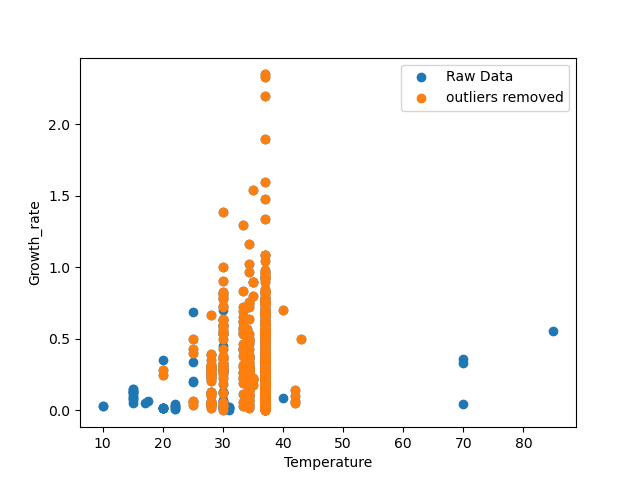

In [38]:
plt.figure()
plt.scatter(knn_imputed_x['Temperature'],y_train,label='Raw Data')
plt.scatter(removed_outliers['Temperature'],youtlier,label='outliers removed')
plt.ylabel('Growth_rate')
plt.xlabel('Temperature')
plt.legend()
plt.savefig('outlier.png')

<IPython.core.display.Javascript object>


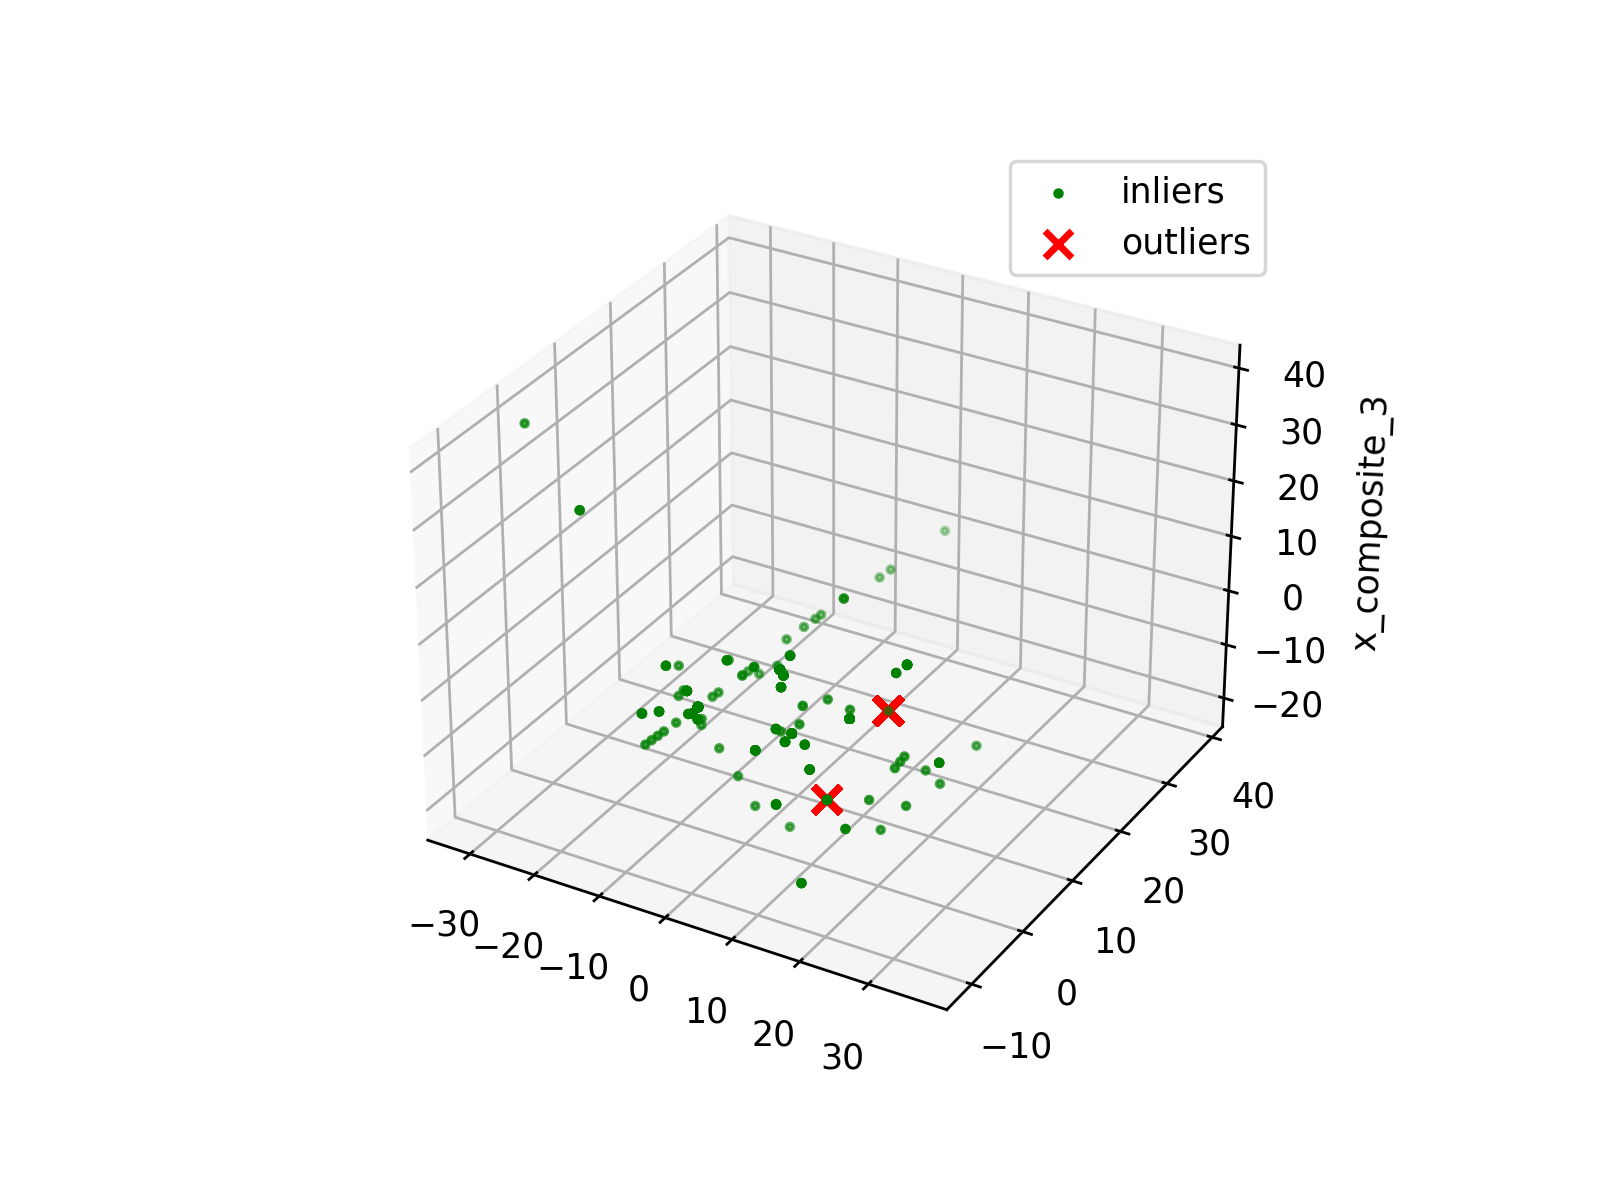

In [40]:
#Visualize the removed outliers
pca = PCA(n_components= 5)  
scaler = StandardScaler()
#normalize the metrics
metrics = x_train.columns
X = scaler.fit_transform(x_train[metrics])
X_reduce = pca.fit_transform(knn_imputed_x)
fig = plt.figure(dpi= 250)
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

In [41]:
# set the data to a single data to not blow out the PCA 
np.where(np.isnan(knn_imputed_x)==True)
scaler = RobustScaler()
scaler.fit(iterative)
scaled_x = scaler.transform(iterative)

## Testing different Models 

In [42]:
#Model Testing
# These are our models that we want to consider
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import svm
from sklearn.naive_bayes import GaussianNB


#We will do a quick look at how these models perform with the default parameter on cross validation
from sklearn.model_selection import cross_val_score
fold =10
##
# print('Logistic regression:', np.mean(cross_val_score(
#     LogisticRegression(random_state=27),imputed_x,y_train)))
scaled = [simple_imputed_x,knn_imputed_x,scaled_x,removed_outliers,iterative]
for index,i in enumerate(scaled): 
    y = y_train
    if index==2:
        scale= 'scaled'
    elif index ==0:
        scale = 'simple imputation'
    elif index == 1: 
        scale = 'knn imputed'
    elif index == 4: 
        scale = 'iterative imputed'
    elif index ==3:
        scale = 'outlier removed'
        y = youtlier
    else:
        scale = ''
    print(np.shape(y))
    print('Using the {} data with {} folds'.format(scale,fold))
    print('Random Forest regressor:',np.mean(cross_val_score(
        RandomForestRegressor(),i,y,cv =fold,scoring = 'neg_root_mean_squared_error')))

    print('K neighbors Regressor:',np.mean(cross_val_score(
        KNeighborsRegressor(),i,y,cv =fold,scoring = 'neg_root_mean_squared_error')))

    print('MLP Regressor:',np.mean(cross_val_score(
        MLPRegressor(max_iter = 2000),i,y,cv =fold,scoring = 'neg_root_mean_squared_error')))

    print('SVM {}:'.format(scale),np.mean(cross_val_score(
        svm.SVR(max_iter = -1,gamma=0.03162277660168379),i,y,cv =fold,scoring = 'neg_root_mean_squared_error')))

    print('Gradient:',np.mean(cross_val_score(
        GradientBoostingRegressor(),i,y,cv =fold, scoring = 'neg_root_mean_squared_error')))
    print('\n')
    
SV = svm.SVR(gamma=1).fit(knn_imputed_x,y_train)
RF = RandomForestRegressor().fit(knn_imputed_x,y_train)
gbr = GradientBoostingRegressor().fit(knn_imputed_x,y_train)
MLP = MLPRegressor().fit(knn_imputed_x,y_train)
KN = KNeighborsRegressor().fit(knn_imputed_x,y_train)


(649,)
Using the simple imputation data with 10 folds
Random Forest regressor: -0.3328631452153679
K neighbors Regressor: -0.3413799479375488
MLP Regressor: -0.348248705995398
SVM simple imputation: -0.31188264218866174
Gradient: -0.31161238513936224


(649,)
Using the knn imputed data with 10 folds
Random Forest regressor: -0.3499793973647304
K neighbors Regressor: -0.37568780545042896
MLP Regressor: -0.35352568138230167
SVM knn imputed: -0.29826321002608136
Gradient: -0.35152578186810707


(649,)
Using the scaled data with 10 folds
Random Forest regressor: -0.32080975642125015
K neighbors Regressor: -0.33858323136033774
MLP Regressor: -0.3149773144207385
SVM scaled: -0.31174413620598723
Gradient: -0.3196352670054103


(552,)
Using the outlier removed data with 10 folds
Random Forest regressor: -0.32309803407817295
K neighbors Regressor: -0.3470863759983265
MLP Regressor: -0.33993744377028046
SVM outlier removed: -0.3004467229280493
Gradient: -0.3326128655028284


(649,)
Using the ite

Fitting 10 folds for each of 5 candidates, totalling 50 fits


<IPython.core.display.Javascript object>


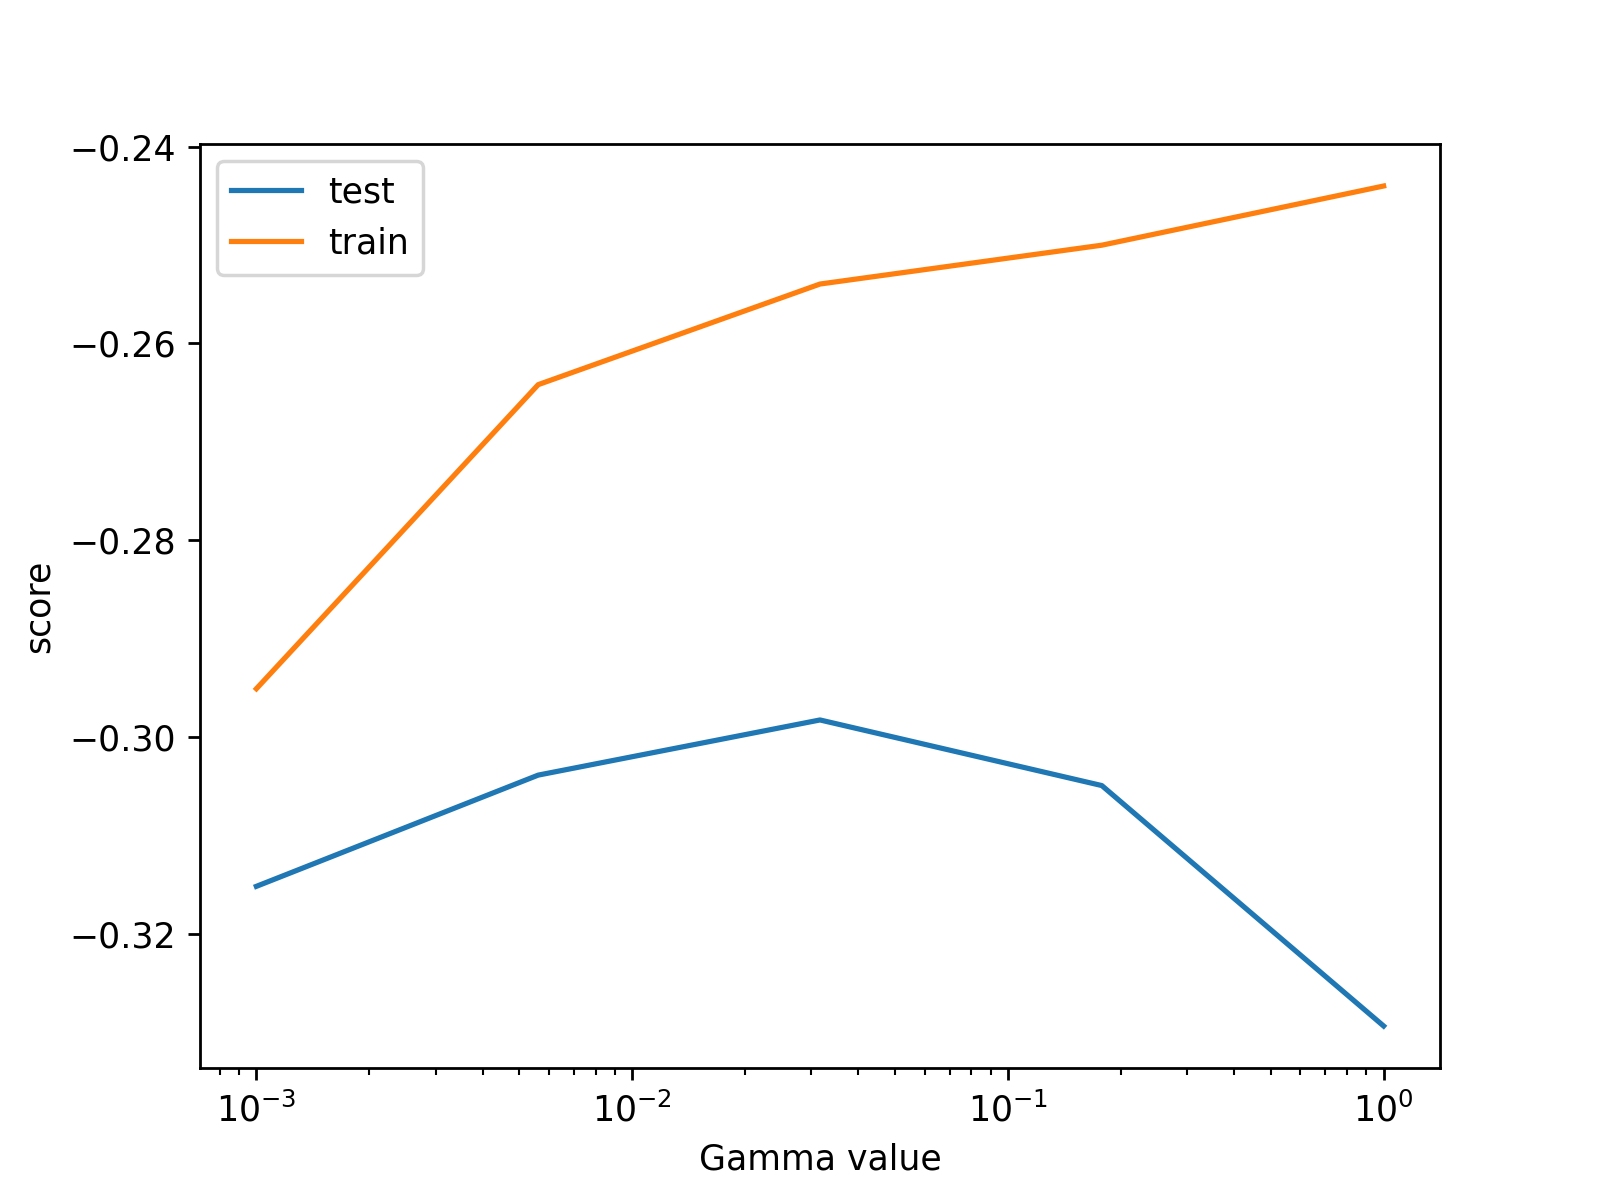

SVR(gamma=0.03162277660168379)

In [66]:
from sklearn.model_selection import GridSearchCV
grid_params = {
   'gamma': np.logspace(-3, 0, 5),
#    'C':np.arange(1,5,step=0.1),
    'kernel':[  'rbf']
    
}

gs = GridSearchCV(
    svm.SVR(),
    grid_params,
    cv=10,
    verbose=1,
    n_jobs=-1,
    return_train_score=True,
    scoring='neg_root_mean_squared_error'
)
clf = gs.fit(knn_imputed_x, y_train)
values = np.logspace(-3, 0, 5)
test_scores = clf.cv_results_['mean_test_score']
train_scores = clf.cv_results_['mean_train_score'] 
plt.figure(dpi=250)
plt.semilogx(values,test_scores, label='test')
plt.semilogx(values,train_scores, label='train')
plt.xlabel('Gamma value')
plt.ylabel('score')
plt.legend(loc='best')
plt.savefig('training_gamma.png')
plt.show()
clf.best_estimator_ 
# print(gs.cv_results_)

In [46]:
values

array([0.001     , 0.00562341, 0.03162278, 0.17782794, 1.        ])

In [47]:
from sklearn.model_selection import GridSearchCV
grid_params = {
   'max_iter': np.arange(0, 500, step=3),
   'alpha':np.arange(0.001,1,step=10)
}

gs = GridSearchCV(
    MLPRegressor(),
    grid_params,
    cv=10,
    verbose=1,
    n_jobs=-1,
    return_train_score=True,
    scoring='neg_root_mean_squared_error'
)
clf = gs.fit(knn_imputed_x, y_train)

test_scores = clf.cv_results_['mean_test_score']
train_scores = clf.cv_results_['mean_train_score'] 
plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()
clf.best_estimator_ 


Fitting 10 folds for each of 167 candidates, totalling 1670 fits


A:\Anaconda\envs\core\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [        nan -2.90827408 -1.2041361  -0.78611623 -0.73821239 -0.71894721
 -0.56299525 -0.52860368 -0.50449658 -0.44454326 -0.4230716  -0.38897977
 -0.38463774 -0.401295   -0.40220908 -0.42219326 -0.3685822  -0.42459122
 -0.38721641 -0.35146081 -0.38339986 -0.4126282  -0.3649513  -0.36064253
 -0.43468098 -0.38961435 -0.3336792  -0.3937483  -0.35943249 -0.39080317
 -0.35430541 -0.35091428 -0.35343784 -0.35389086 -0.34118302 -0.37396757
 -0.3817999  -0.34762794 -0.3730599  -0.36118889 -0.33478898 -0.36761559
 -0.36599104 -0.34050035 -0.36513203 -0.35957402 -0.37534143 -0.34963091
 -0.33702604 -0.35785332 -0.37751211 -0.33066309 -0.414607   -0.35077739
 -0.3668077  -0.34499213 -0.35733851 -0.34456802 -0.33461346 -0.3645245
 -0.30280092 -0.36991308 -0.39208018 -0.36970082 -0.3488435  -0.3503827
 -0.31966608 -0.3535042  -0.41540062 -0.37597178 -0.3729752

MLPRegressor(alpha=0.001, max_iter=180)

In [48]:
from sklearn import set_config                      # to change the display
from sklearn.utils import estimator_html_repr       # to save the diagram into HTML format\


# set config to diagram for visualizing the pipelines/composite estimators
set_config(display='diagram')

# Lets visualize the best estimator from grid search.
gs.best_estimator_

# saving pipeline as html format
with open('titanic_data_pipeline_estimator.html', 'w') as f:  
    f.write(estimator_html_repr(gs.best_estimator_))

<IPython.core.display.Javascript object>


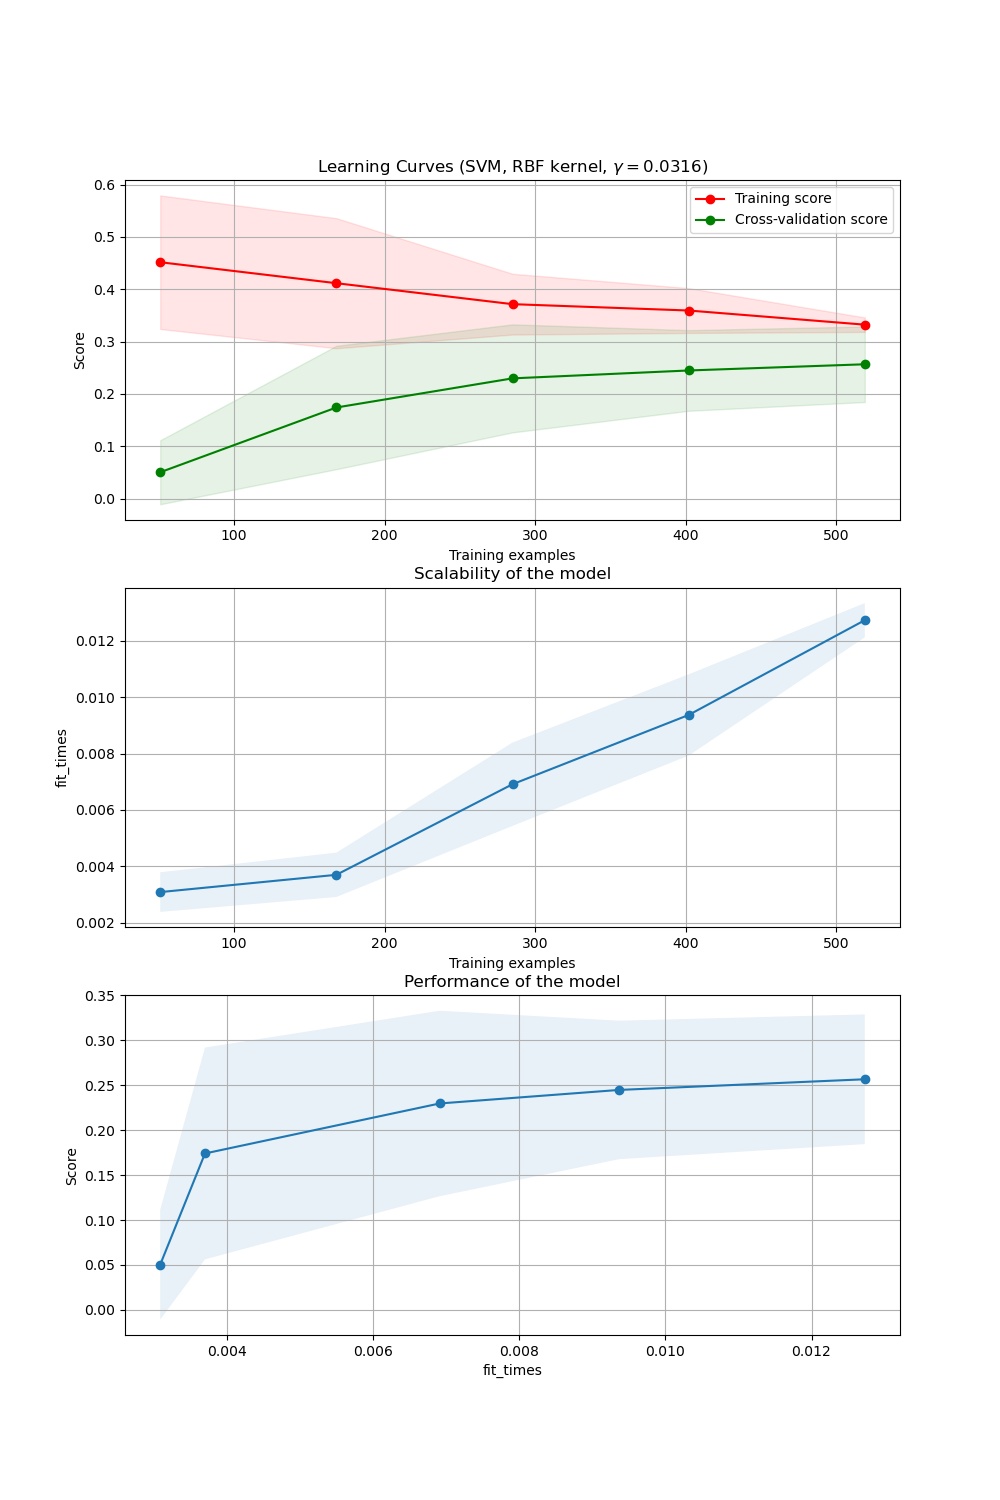

In [49]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
           _, axes = plt.subplots(1, 3, figsize=(20, 5))
        

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 1, figsize=(10, 15))

title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.0316$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = svm.SVR(gamma=0.0316)
plot_learning_curve(estimator, title, knn_imputed_x, y_train, axes=axes[:],
                    cv=cv, n_jobs=4)
plt.savefig('learning_curve.png')
plt.show()


<IPython.core.display.Javascript object>


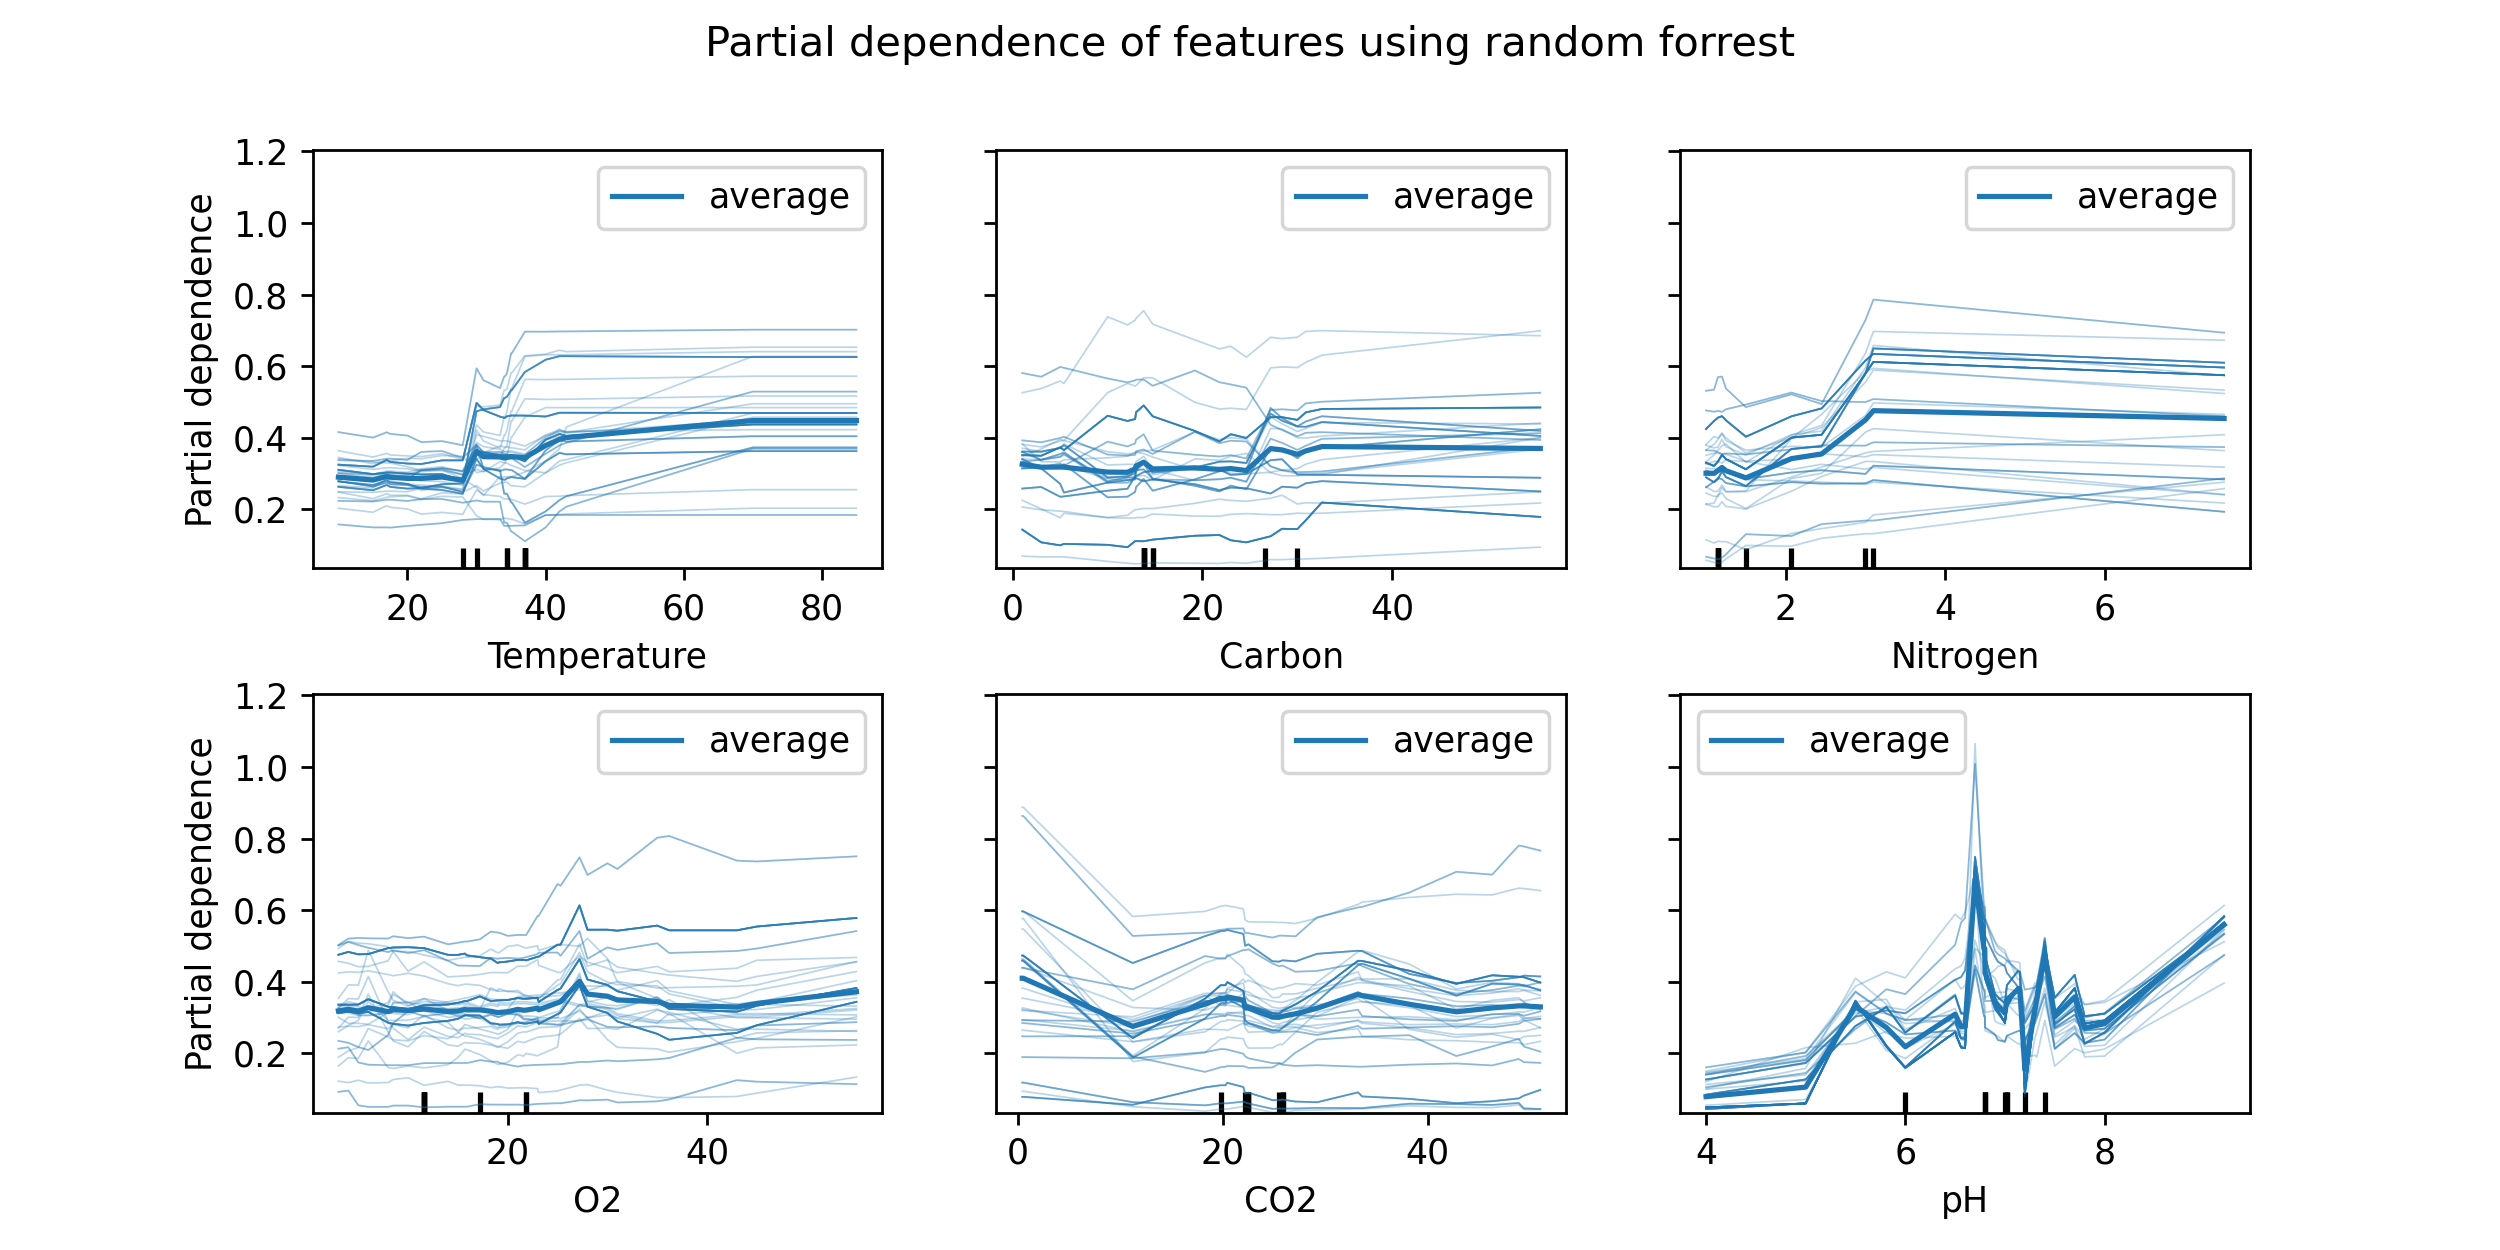

<IPython.core.display.Javascript object>


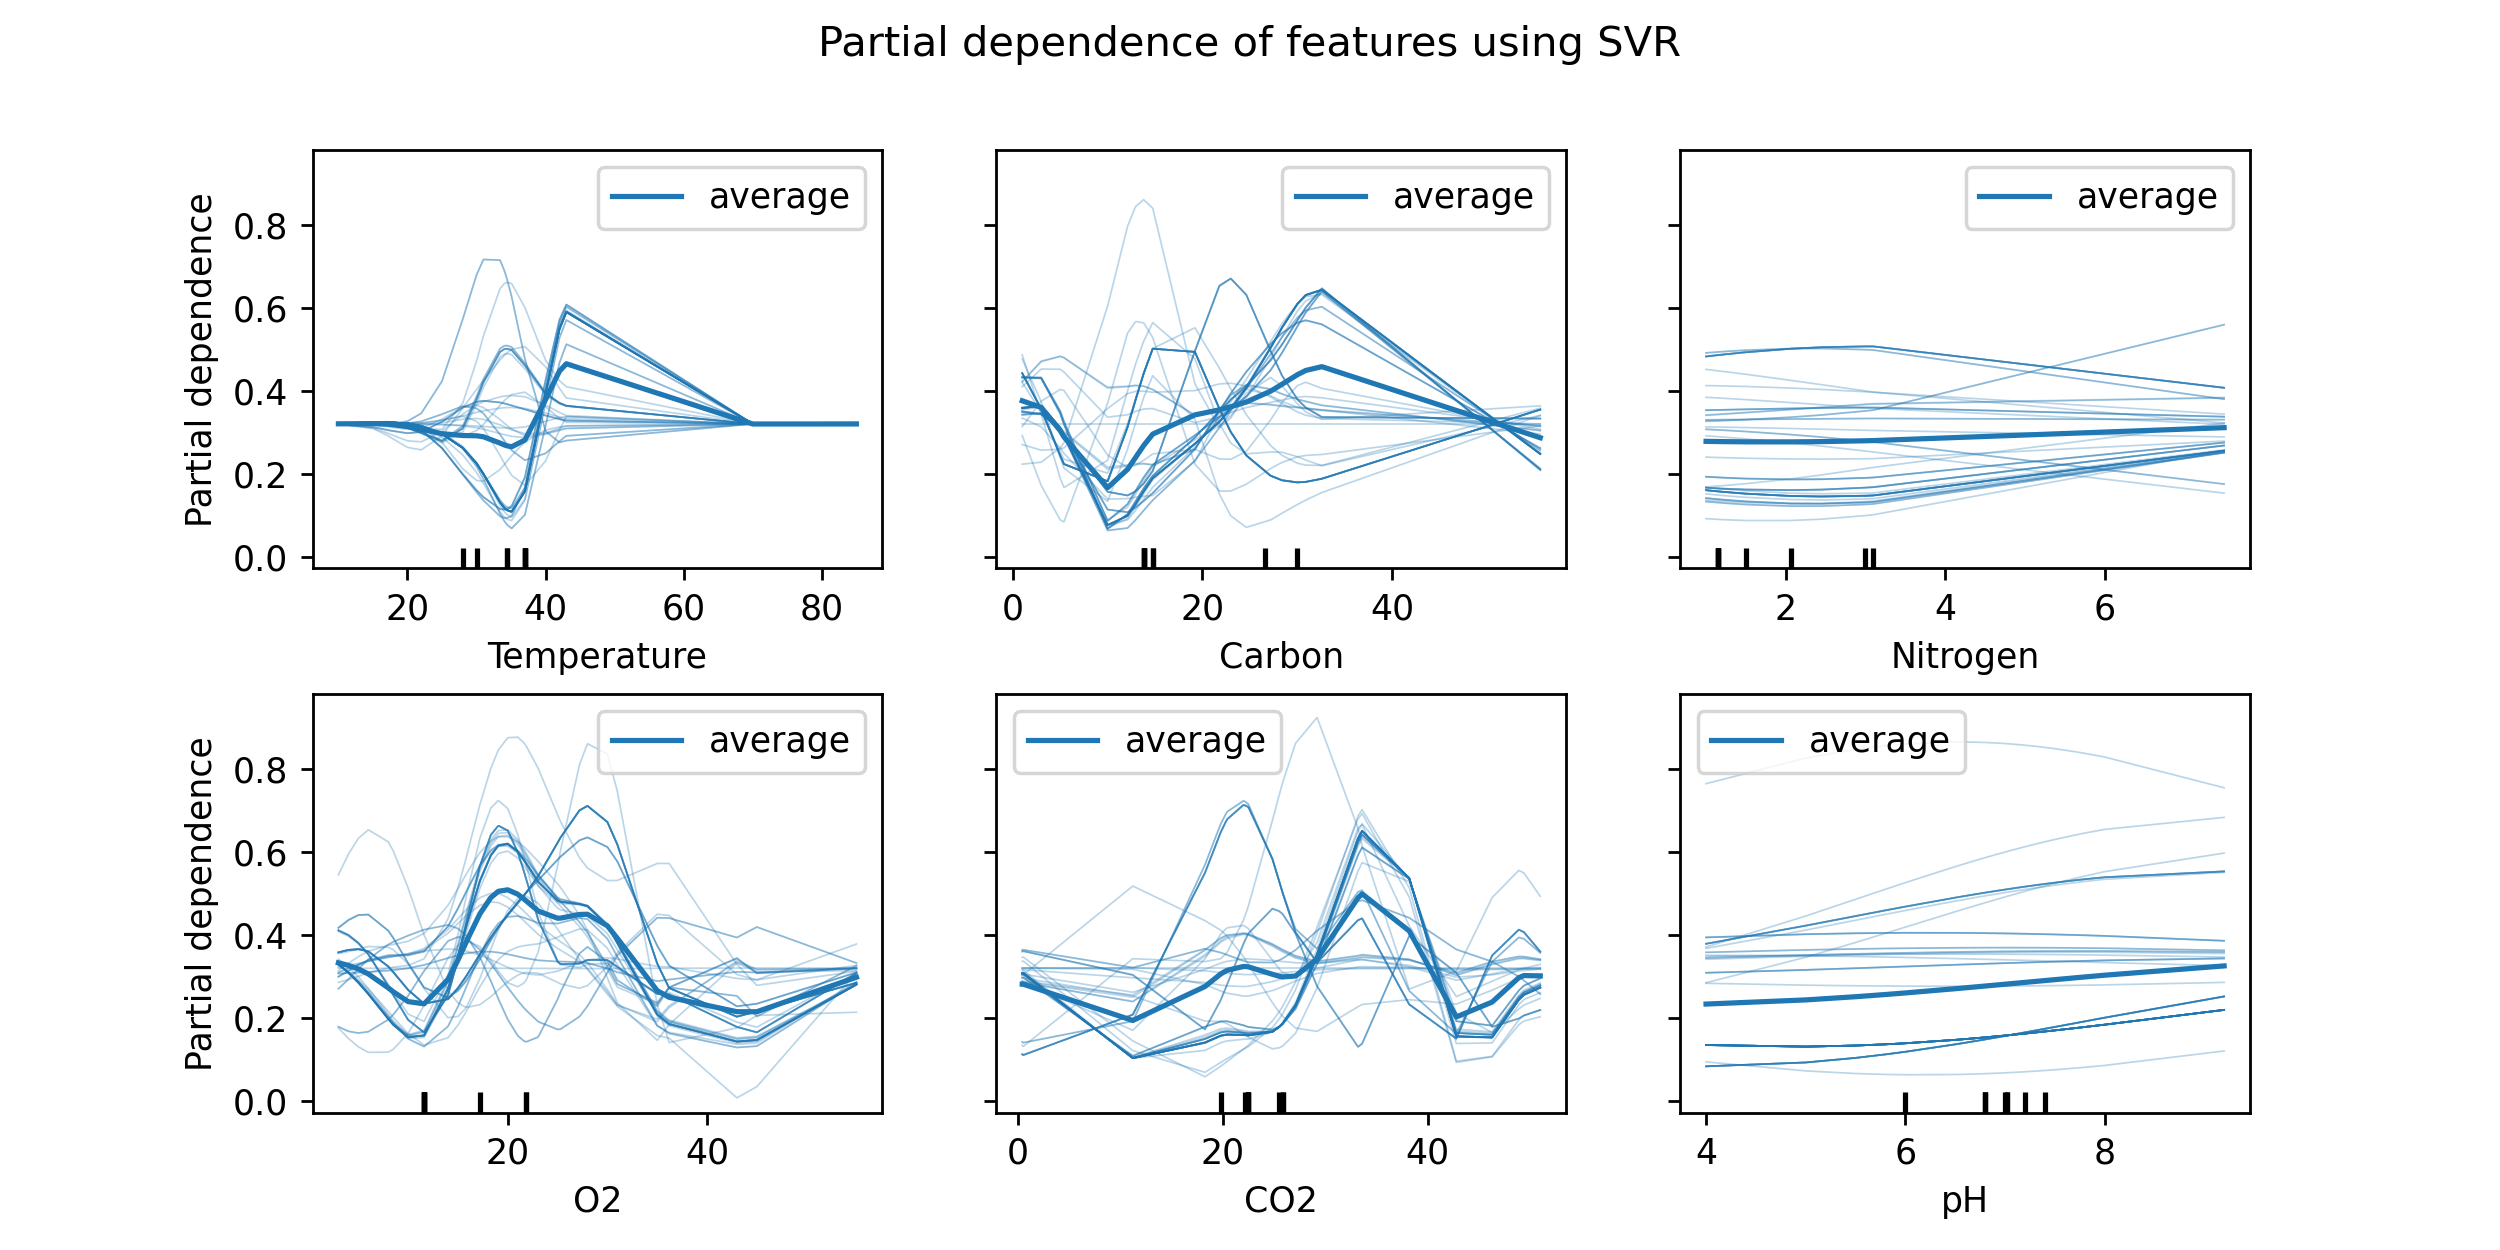

<IPython.core.display.Javascript object>


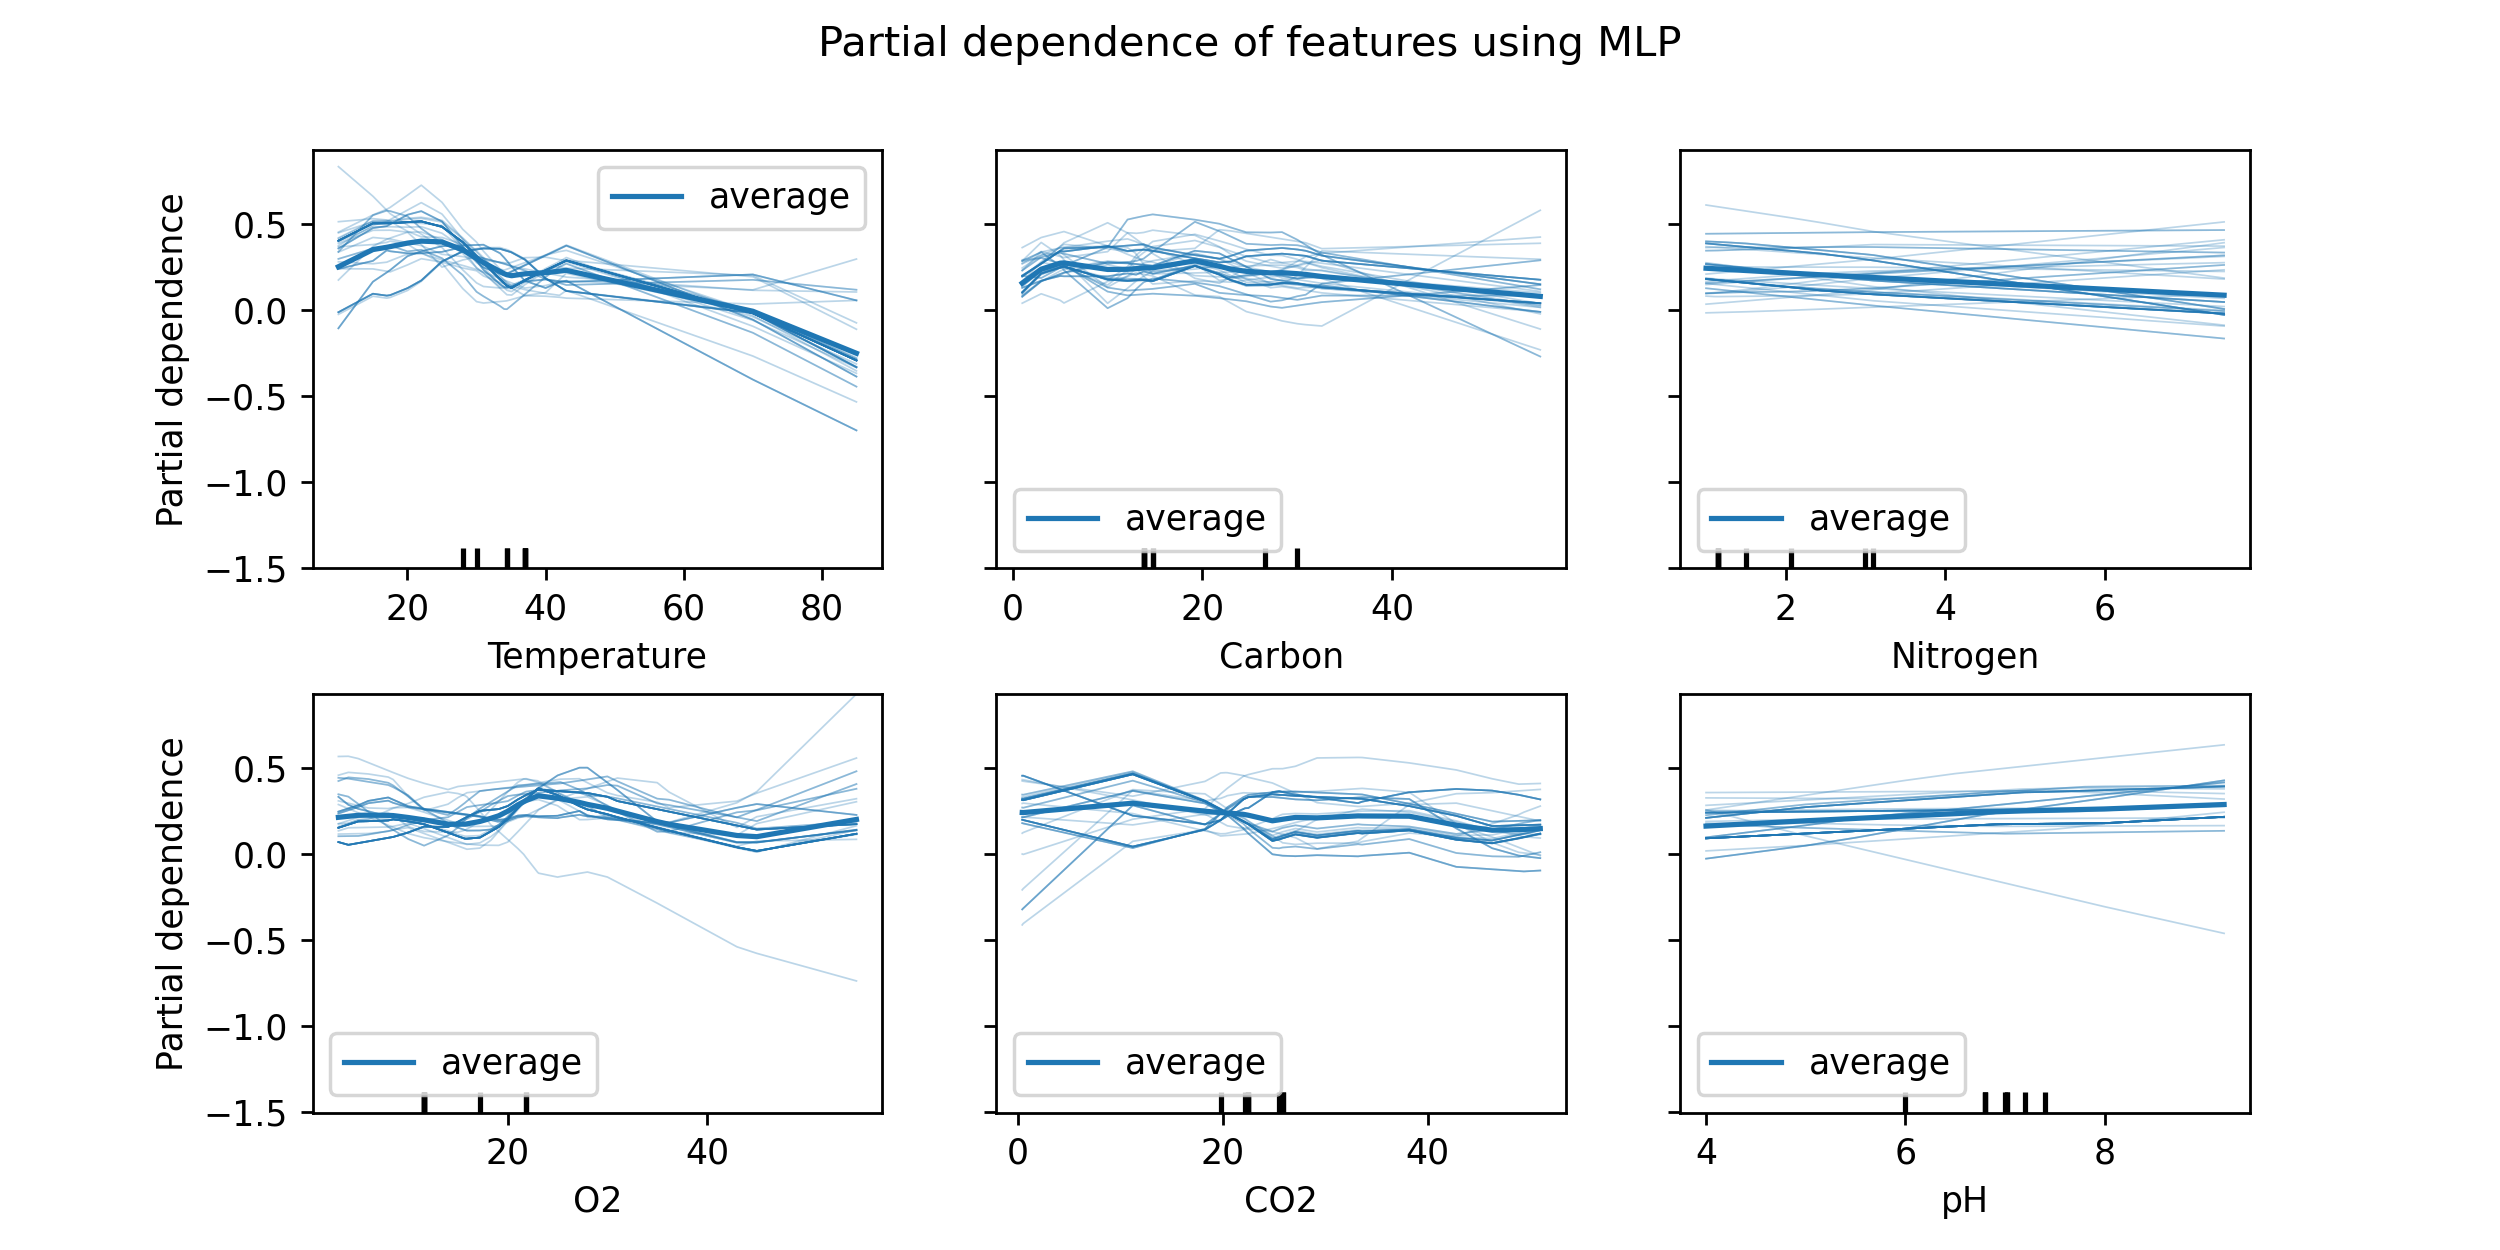

<IPython.core.display.Javascript object>


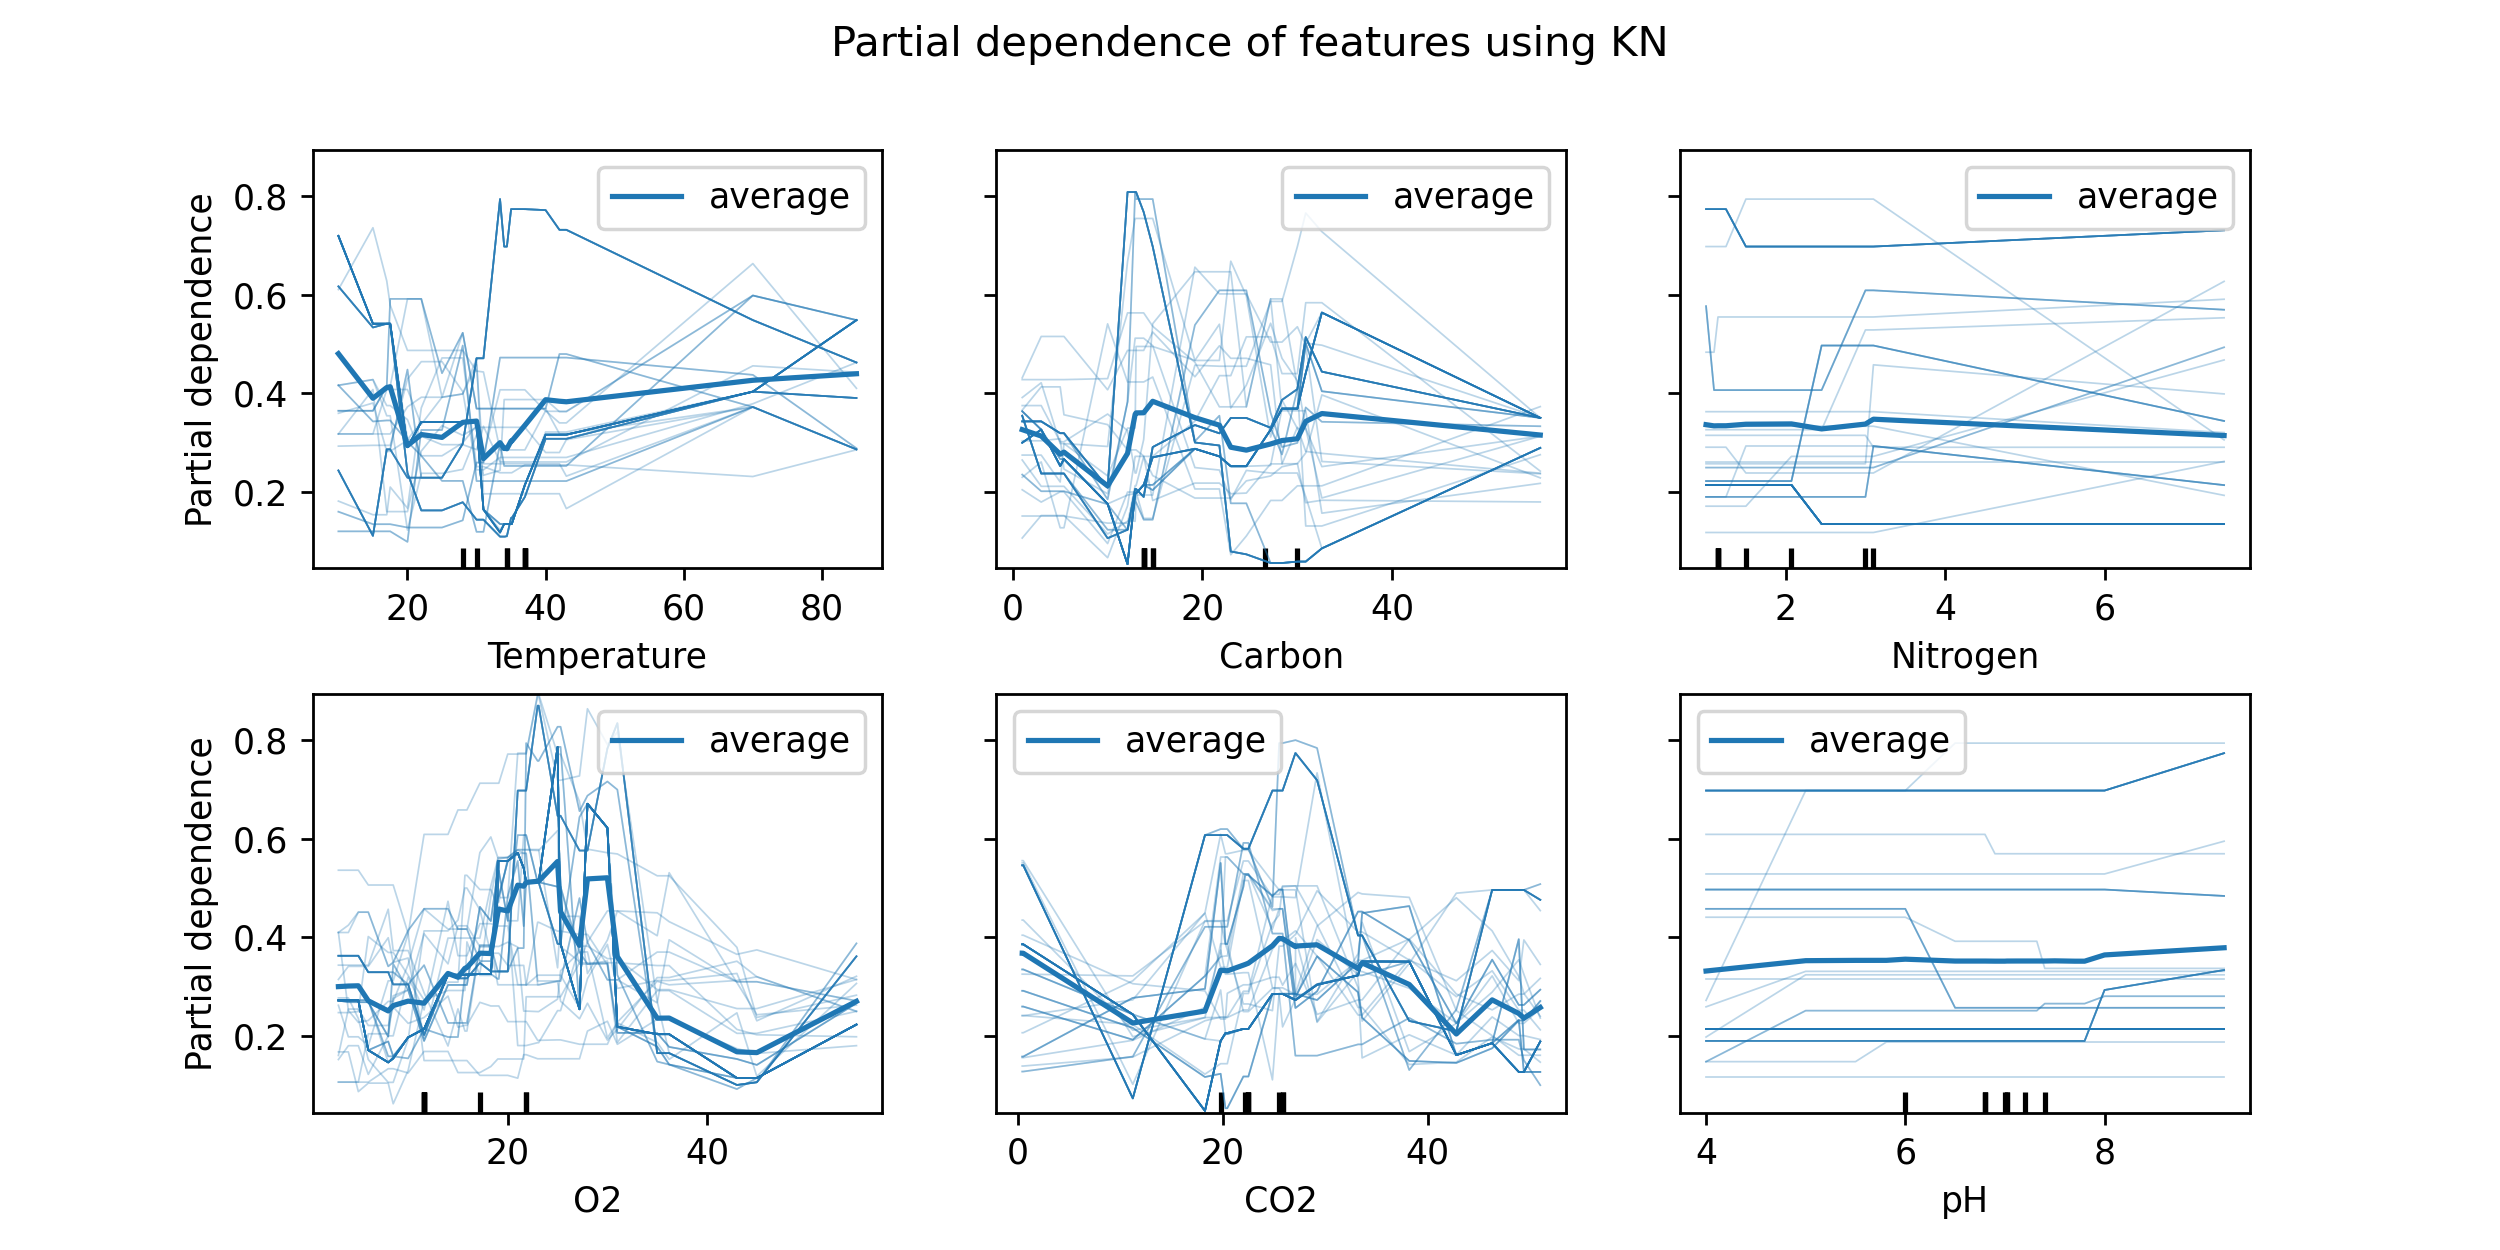

<IPython.core.display.Javascript object>


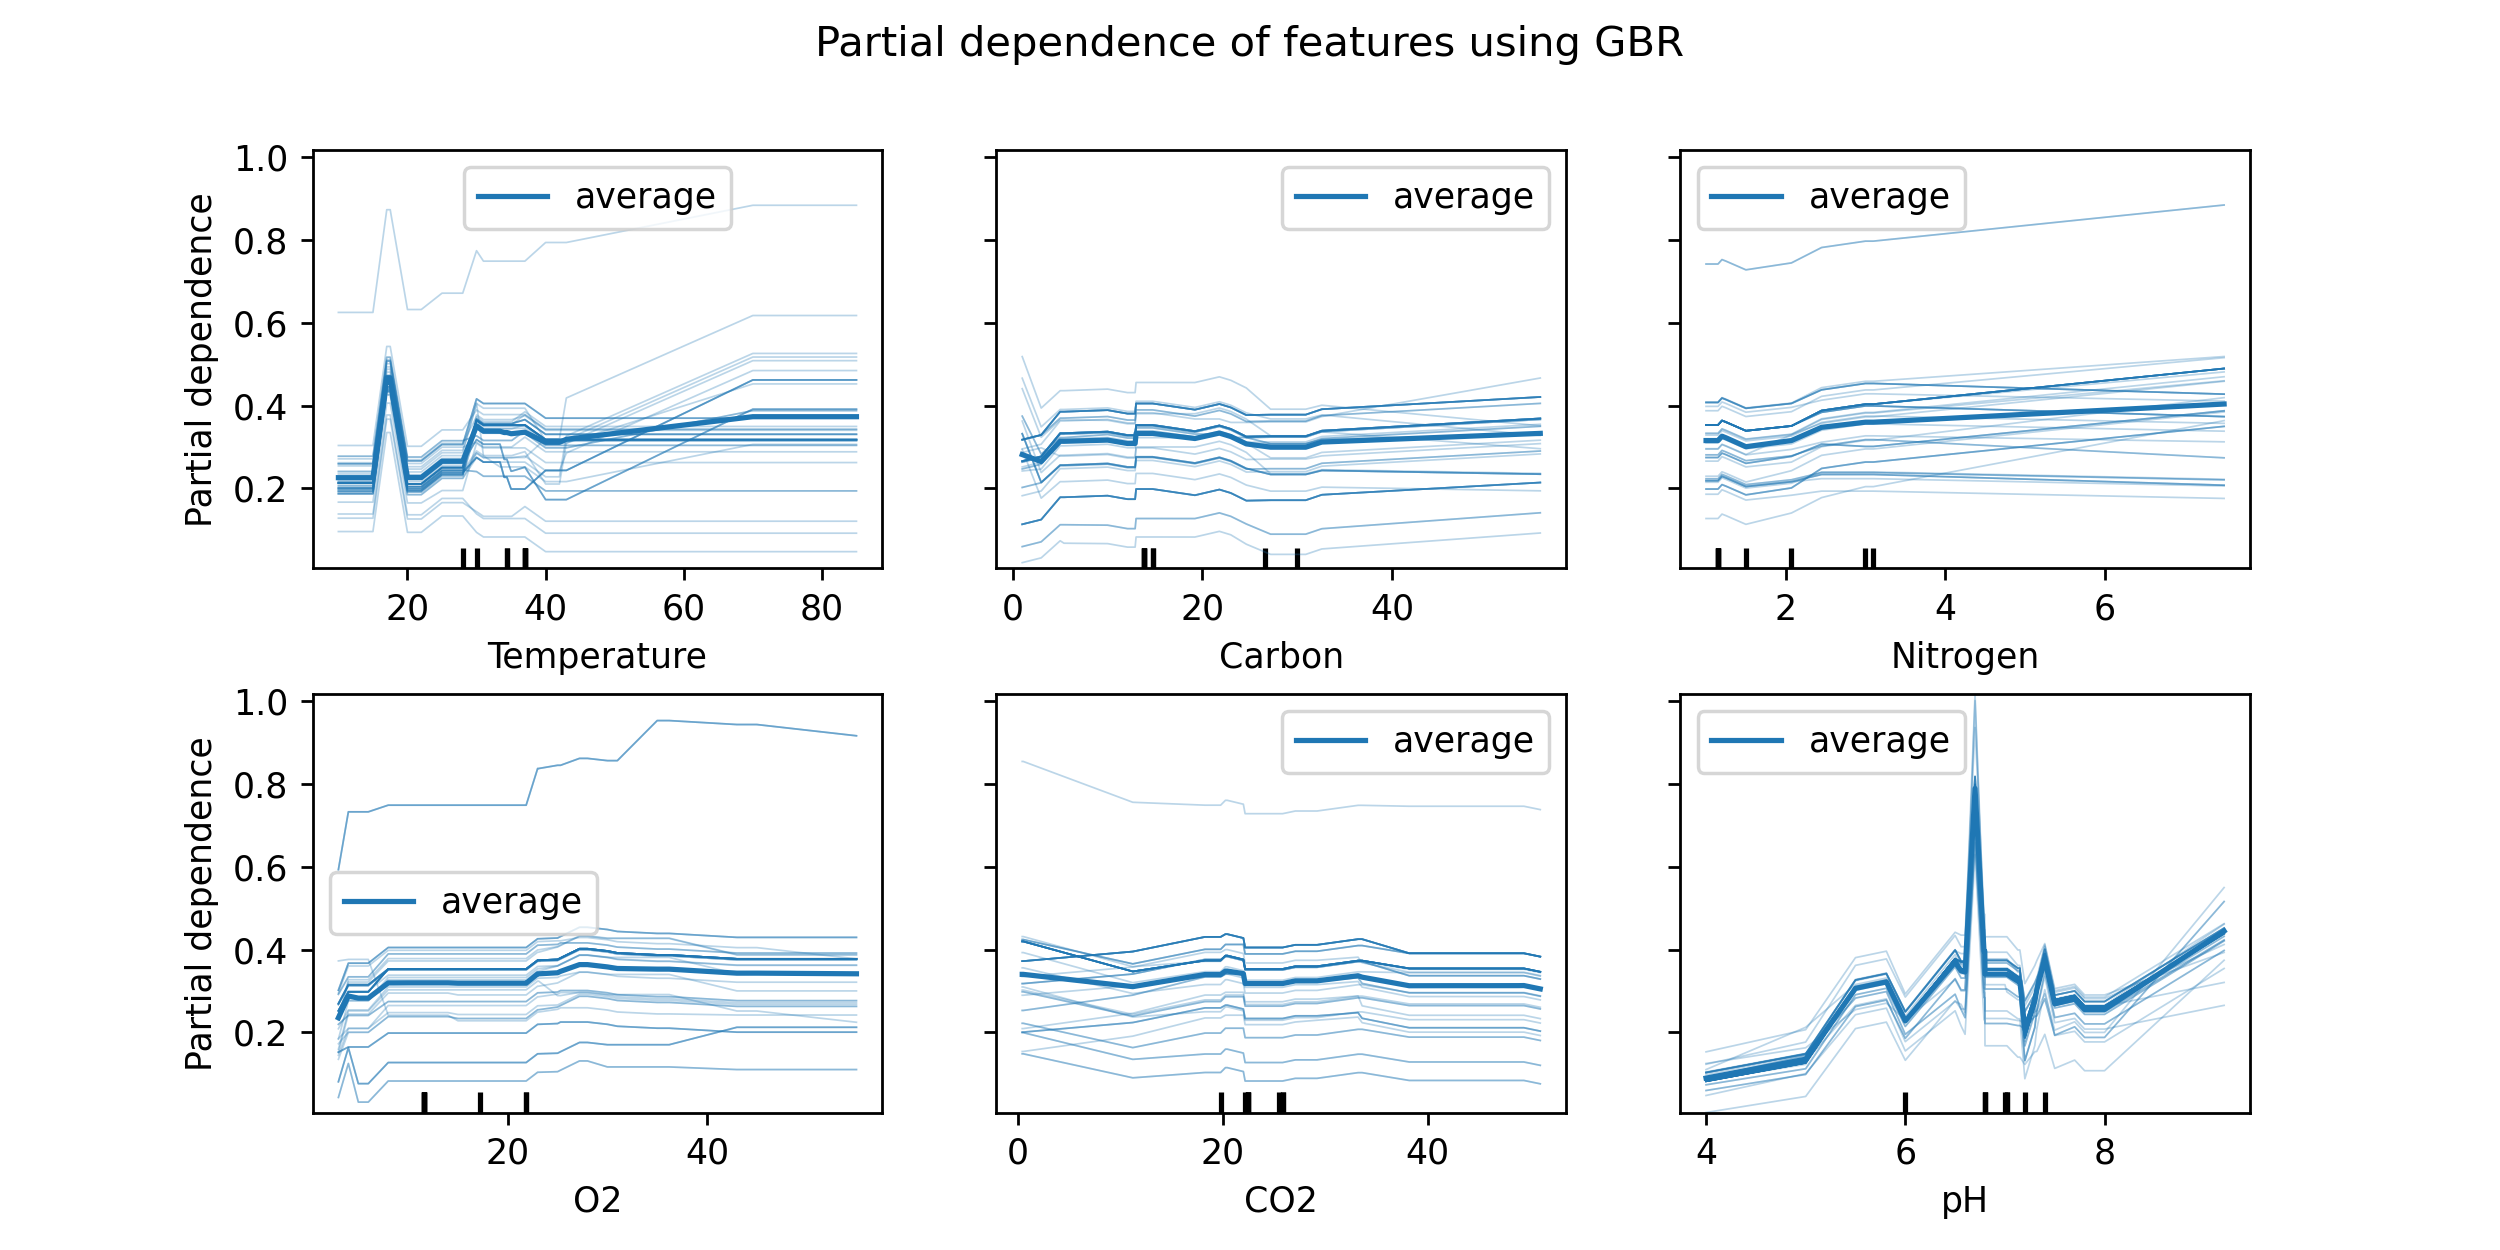

In [50]:
from sklearn.inspection import plot_partial_dependence

SV = svm.SVR(gamma=0.03).fit(iterative,y_train)
RF = RandomForestRegressor().fit(iterative,y_train)
gbr = GradientBoostingRegressor().fit(iterative,y_train)
MLP = MLPRegressor(max_iter=423).fit(iterative,y_train)
KN = KNeighborsRegressor().fit(iterative,y_train)
subsample = 50
kind='both'

display = plot_partial_dependence(RF, knn_imputed_x, x_train.columns,subsample=subsample,kind=kind)
display.figure_.suptitle(
    'Partial dependence of features using random forrest')
display.figure_.subplots_adjust(hspace=0.3)
fig = plt.gcf()
fig.set_size_inches(10,5)
fig.set_dpi(250)


display = plot_partial_dependence(SV, knn_imputed_x, x_train.columns,subsample=subsample,kind=kind)
display.figure_.suptitle(
    'Partial dependence of features using SVR')
display.figure_.subplots_adjust(hspace=0.3)
fig = plt.gcf()
fig.set_size_inches(10,5)
fig.set_dpi(250)
fig.savefig('SVR partial Dependence')
display = plot_partial_dependence(MLP, knn_imputed_x, x_train.columns,subsample=subsample,kind=kind)
display.figure_.suptitle(
    'Partial dependence of features using MLP')
display.figure_.subplots_adjust(hspace=0.3)
fig = plt.gcf()
fig.set_size_inches(10,5)
fig.set_dpi(250)

display = plot_partial_dependence(KN, knn_imputed_x, x_train.columns,subsample=subsample,kind=kind)
display.figure_.suptitle(
    'Partial dependence of features using KN')
display.figure_.subplots_adjust(hspace=0.3)
fig = plt.gcf()
fig.set_size_inches(10,5)
fig.set_dpi(250)

display = plot_partial_dependence(gbr, knn_imputed_x, x_train.columns,subsample=subsample,kind=kind)
display.figure_.suptitle(
    'Partial dependence of features using GBR')
display.figure_.subplots_adjust(hspace=0.3)
fig = plt.gcf()
fig.set_size_inches(10,5)
fig.set_dpi(250)
fig.savefig('gbr')


<IPython.core.display.Javascript object>


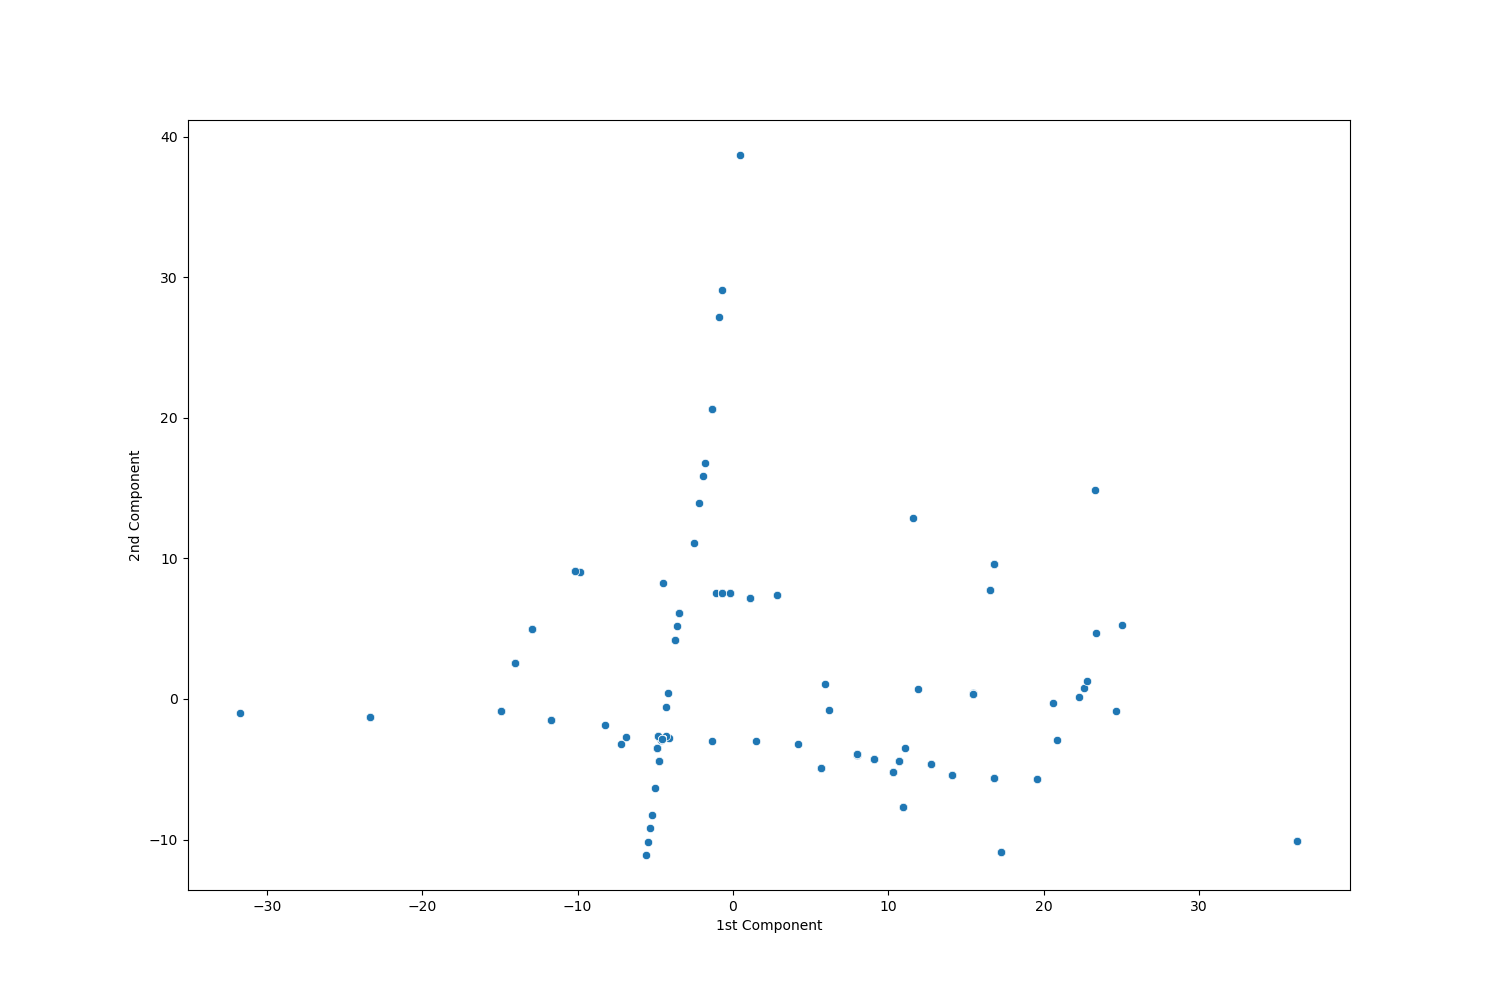

[0.55965187 0.23444842 0.11470244 0.08659992 0.00337137]
[[0.55653744 0.8106248  0.08602876 0.11653625 0.11030882 0.00195707]
 [0.02146094 0.15656638 0.00859892 0.95762701 0.24054877 0.0062656 ]
 [0.80982469 0.51775106 0.01057254 0.00264341 0.27527427 0.01493697]
 [0.18033595 0.21093246 0.00891922 0.26231022 0.92393099 0.02125492]
 [0.00126589 0.01724995 0.15053782 0.00813774 0.02315387 0.98814821]]


In [64]:
from sklearn.decomposition import PCA
pca = PCA(n_components= 5)  
# print(imputed_x)
X_proj  = pca.fit_transform(knn_imputed_x)
# print(X_proj)
principalDf = pd.DataFrame(data = X_proj
             , columns = ['principal component 1', 'principal component 2',
                          'principal component 3','principal component 4','principal component 5'])
finalDf = pd.concat([principalDf,y_train], axis = 1)

fig, axes = plt.subplots(figsize=(15,10))

sns.scatterplot(x= X_proj[:, 0], y= X_proj[:, 1],
             ax=axes)
fig.suptitle("")
plt.xlabel('1st Component')
plt.ylabel('2nd Component')
# plt.colorbar()
# plt.legend()
plt.show()
print(pca.explained_variance_ratio_)
print(abs( pca.components_ ))

In [53]:
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedKFold
from sklearn.tree import DecisionTreeRegressor
rfe = RFECV(estimator=DecisionTreeRegressor())
model = DecisionTreeRegressor()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, knn_imputed_x, y_train, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

MAE: -0.276 (0.033)


In [55]:
from sklearn.feature_selection import RFE
rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=1)
rfe.fit(knn_imputed_x,y_train)
for i in range(knn_imputed_x.shape[1]):
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected False, Rank: 5.000
Column: 1, Selected True, Rank: 1.000
Column: 2, Selected False, Rank: 6.000
Column: 3, Selected False, Rank: 3.000
Column: 4, Selected False, Rank: 4.000
Column: 5, Selected False, Rank: 2.000


Optimal number of features : 1


<IPython.core.display.Javascript object>


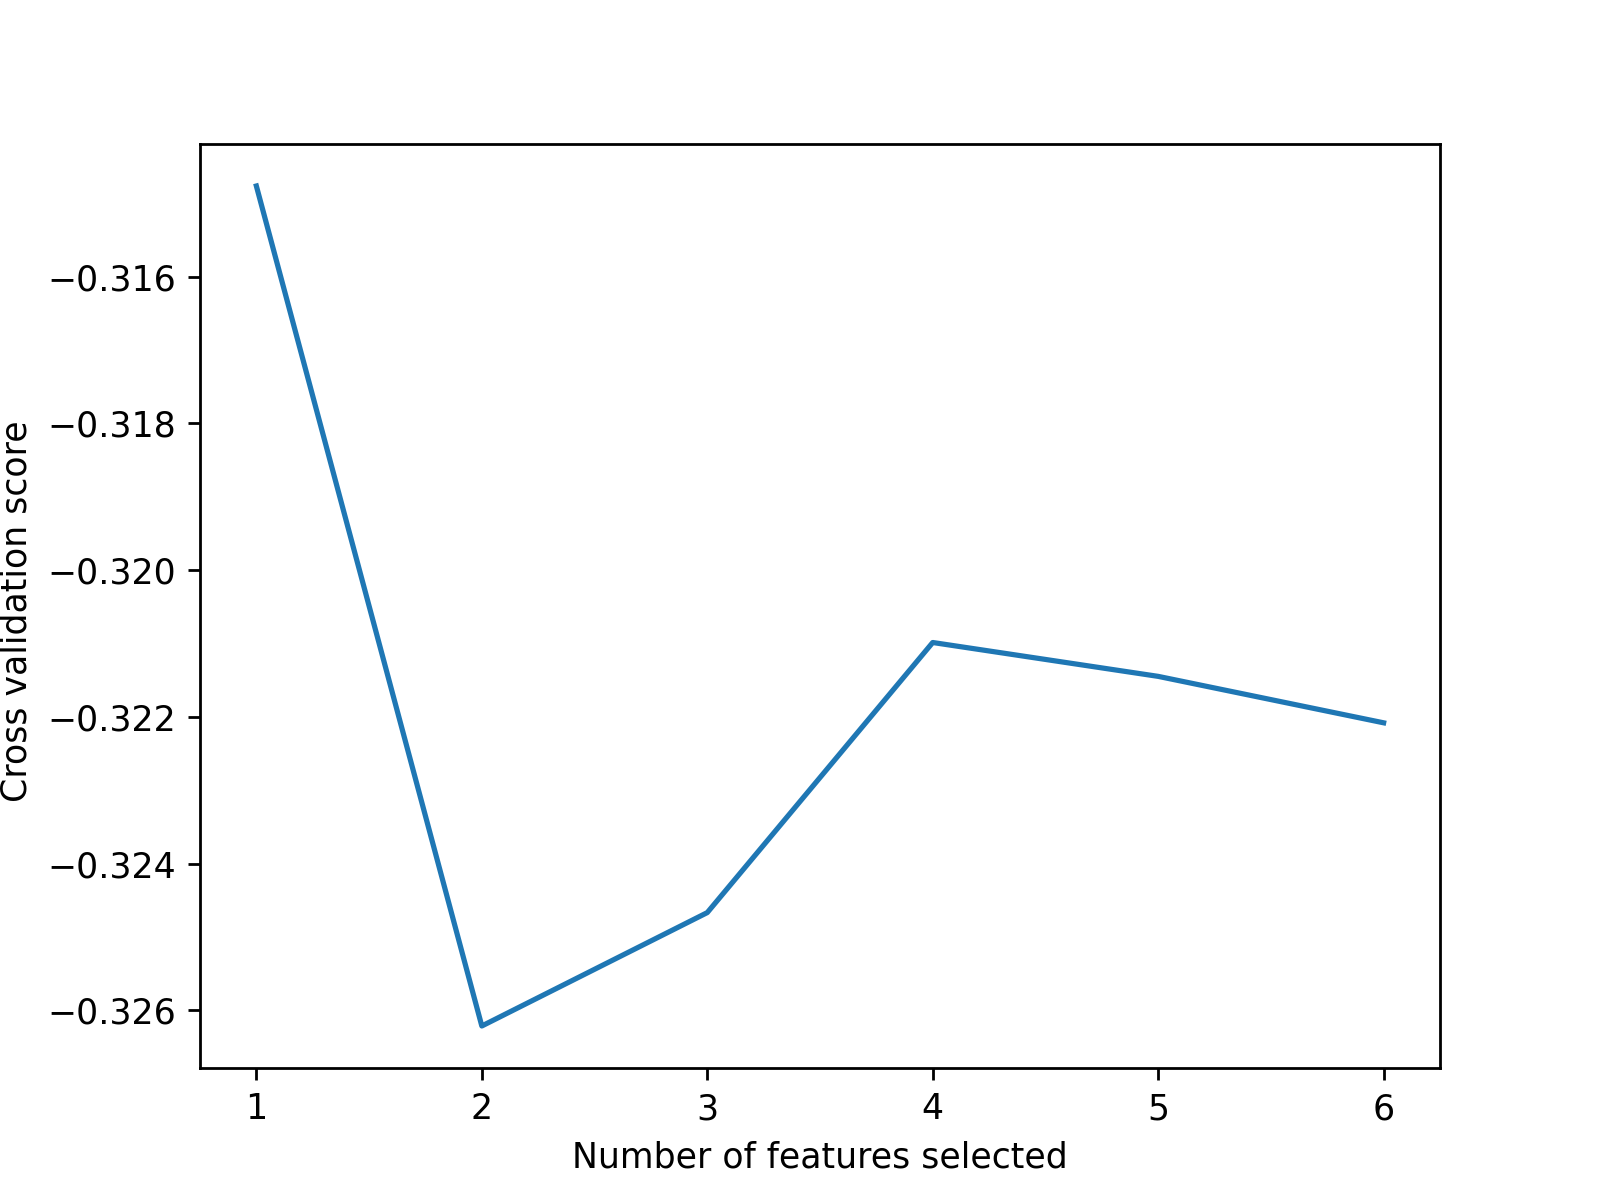

In [57]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

# Build a classification task using 3 informative features


# Create the RFE object and compute a cross-validated score.
svc = svm.SVR(kernel='linear')
svc.fit(knn_imputed_x,y_train)
# The "accuracy" scoring is proportional to the number of correct
# classifications
# svc.fit(knn_imputed_x, y_train)
min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(estimator=svc, step=1, cv=KFold(n_splits=10),
              scoring='neg_root_mean_squared_error',
              min_features_to_select=min_features_to_select)
rfecv.fit(knn_imputed_x, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure(dpi=250)
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score ")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.savefig('featureSelection.png')
plt.show()

In [92]:
final_x = knn_imputed_x.drop(['pH','Nitrogen'],axis=1)
final_justemp = final_x['Temperature'].to_numpy()
final_justtemp = final_justemp.reshape(-1,1)

In [93]:
  print('SVM {}:'.format(scale),np.mean(cross_val_score(
        svm.SVR(max_iter = -1),final_justtemp,y_train,cv =10,scoring = 'neg_root_mean_squared_error')))

SVM iterative imputed: -0.3057361076025229
